<a href="https://colab.research.google.com/github/ariftoteles/Telecom-Customer-Churn/blob/master/Notebook/Telcom_Customer_Churn_Best_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Model

- Pada Notebook ini akan dibangun Supervised Machine Learning menggunakan metode Logisitic Regression, XGBoost Classifier, Random Forest, dan K-Nearest Neighbors.
- Class label pada dataset tidak seimbang, label Not Churn : 5163, label Chrun : 1869. 
- Saya akan melakukan 4 percobaan:
    1. Training model menggunakan dataset Imbalance
    2. Training model menggunakan dataset balance (Under Sample)
    3. Training model menggunakan dataset balance (Random Over Sample)
    4. Training model menggunakan dataset balance Synthetic Minority Oversampling Technique(SMOTE)
- Dalam evaluasi model ini saya menggunakan data test imbalance, karena model ini dibangun untuk memprediksi kemungkinan customer untuk churning (memprediksi class label : 1), saya akan menggunakan __AUC__ , __F1 Score(1)__ dan __Recall(1) / Sensitivity__ sebagai acuan utama mengukur peforma model.
- Feature Monthly Charges dan Total Charges tidak akan digunakan sebagai variable prediktor dengan pertimbangan sebagai berikut :
    - 2 Feature tersebut merupakan feature dependent, hal ini sudah dibuktikan pada notebook EDA sebelumnya
    - 2 feature ini akan menyulitkan user untuk melakukan input nilai pada model interface

- Sebelum saya benar benar membuang feature tersebut, saya akan melihat perbandingan model yang menggunakan 2 feature tersebut dan yang tidak menggunakan 2 feature tersebut.

## Load Library and Dataset

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score,f1_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline

import warnings
warnings.filterwarnings("ignore")

In [19]:
pd.set_option("display.max_columns", 22)
telcom = pd.read_csv('/content/telcom_clean1.csv')
telcom.head()

,customerID,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,Churn,gender_Female,gender_Male,MultipleLines_No,MultipleLines_No phone service,...,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,tenure,MonthlyCharges,TotalCharges
0,7590-VHVEG,0,1,0,0,1,0,1,0,0,1,...,0,0,1,0,0,1,0,0,-1.280248,-1.161694,-0.994194
1,5575-GNVDE,0,0,0,1,0,0,0,1,1,0,...,0,0,1,0,0,1,0,0,0.064303,-0.260878,-0.173740
2,3668-QPYBK,0,0,0,1,1,1,0,1,1,0,...,0,0,1,0,0,1,0,0,-1.239504,-0.363923,-0.959649
3,7795-CFOCW,0,0,0,0,0,0,0,1,0,1,...,0,1,1,0,0,1,0,0,0.512486,-0.747850,-0.195248
4,9237-HQITU,0,0,0,1,1,1,1,0,1,0,...,0,0,1,0,0,1,0,0,-1.239504,0.196178,-0.940457


In [20]:
telcom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 43 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   customerID                               7032 non-null   object 
 1   SeniorCitizen                            7032 non-null   int64  
 2   Partner                                  7032 non-null   int64  
 3   Dependents                               7032 non-null   int64  
 4   PhoneService                             7032 non-null   int64  
 5   PaperlessBilling                         7032 non-null   int64  
 6   Churn                                    7032 non-null   int64  
 7   gender_Female                            7032 non-null   int64  
 8   gender_Male                              7032 non-null   int64  
 9   MultipleLines_No                         7032 non-null   int64  
 10  MultipleLines_No phone service           7032 no

# 1. Percobaan 1 (Imbalance Dataset)

- Training Model menggunakan Imbalance dataset
- Menggunakan semua feature sebagai variable prediktor kecuali Customer ID

### Spliting Data

In [21]:
## train test split
pd.set_option("display.max_columns", 33)
#splitting train and test data 
feature    = telcom.drop(columns=['customerID','Churn'])
target = telcom['Churn']
train_X,test_X,train_Y,test_Y = train_test_split(feature,target,test_size = .25,random_state=123)
feature.columns

Index(['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'PaperlessBilling', 'gender_Female', 'gender_Male', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'OnlineSecurity_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No',
       'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', '

In [33]:
train_X = np.array(train_X)
train_Y = np.array(train_Y)
test_X = np.array(test_X)
test_Y = np.array(test_Y)

### Deklarasi Model

Pada deklarasi model ini, saya akan langsung melakukan Hyperparameter Tuning menggunakan ```GridSearchCV``` , karena menggunakan class imbalance, pada hyperparameter saya menggunakan scoring __F1 Score__

__Parameter Tuning Logistic Regression__

In [23]:
# param_lr = {
#     'solver':['newton-cg','lbfgs','liblinear','sag','saga'], ##algoritma Logistic regression
#     'penalty':['none','l1','l2','elasticnet','none'], # regularisasi
#       'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] #strong of regularisasi
# }
param_lr = {
    'solver':['saga'], ##algoritma Logistic regression
    'penalty':['none'], # regularisasi
    'C': [0.001] #strong of regularisasi
}
kf = KFold(n_splits=5, random_state=111, shuffle=False)

lr_pipeline = make_pipeline(LogisticRegression())
new_params = {'logisticregression__' + key: param_lr[key] for key in param_lr}
lr_tune = GridSearchCV(lr_pipeline, param_grid=new_params, cv=kf, scoring='f1',
                        return_train_score=True)
lr_tune.fit(train_X, train_Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_class='auto',
                                                           n_jobs=None,
                                                           penalty='l2',
                                                  

In [8]:
# lr_tune.best_params_

# {'logisticregression__C': 0.001,
#  'logisticregression__penalty': 'none',
#  'logisticregression__solver': 'saga'}

__Parameter Tuning XGBoost__

In [32]:
# param =  {"learning_rate"    : [int(x)/100 for x in np.linspace(1, 10, 10)] ,
#           "min_child_weight" : [int(x) for x in np.linspace(1, 10, 10)],
#           "gamma"            : [int(x)/10 for x in np.linspace(1, 10, 10)],
#           "max_depth"        : [int(x) for x in np.linspace(1, 10, 10)] ,
#           "colsample_bytree" : [int(x)/10 for x in np.linspace(1, 10, 10)] }

param =  {"learning_rate"    : [0.05] ,
          "min_child_weight" : [7],
          "gamma"            : [0.2],
          "max_depth"        : [5] ,
          "colsample_bytree" : [0.7] }

xgb = XGBClassifier()
xgb_tune = RandomizedSearchCV(xgb, param,cv=5 , n_iter=10, random_state=20,verbose=1)
xgb_tune.fit(train_X, train_Y)
print(xgb_tune.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s finished


{'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.3}


In [26]:
# {'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.3}

__Parameter Tuning Random Forest__

In [28]:
# param= {
#     'n_estimators': [10,50,100], ## jumlah tree
#     'criterion':['gini','entropy'], ## algoritma tree
#     'max_depth': [int(x) for x in np.linspace(10, 100, 10)],
# }

param= {
    'n_estimators': [50], ## jumlah tree
    'criterion':['entropy'], ## algoritma tree
    'max_depth': [10],
}
kf = KFold(n_splits=5, random_state=111, shuffle=False)

rf_pipeline = make_pipeline(RandomForestClassifier())
new_params = {'randomforestclassifier__' + key: param[key] for key in param}
rf_tune = GridSearchCV(rf_pipeline, param_grid=new_params, cv=kf, scoring='f1',
                        return_train_score=True)
rf_tune.fit(train_X, train_Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('randomforestclassifier',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               max_samples=None,
                                                               min_impurity_decrease=0.0,
                                                     

In [ ]:
# rf_tune.best_params_

# {'randomforestclassifier__criterion': 'entropy',
#  'randomforestclassifier__max_depth': 10,
#  'randomforestclassifier__n_estimators': 50}

{'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__n_estimators': 50}

__Parameter Tuning KNN__

In [29]:
# param = {
#         'n_neighbors' : list(range(50,100)), ## jumlah n neighbors
#         'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'], # struktur data
# }

param = {
        'n_neighbors' : [63], ## jumlah n neighbors
        'algorithm':['auto'], # struktur data
}
kf = KFold(n_splits=5, random_state=111, shuffle=False)

knn_pipeline = make_pipeline(KNeighborsClassifier())
new_params = {'kneighborsclassifier__' + key: param[key] for key in param}
knn_tune = GridSearchCV(knn_pipeline, param_grid=new_params, cv=kf, scoring='f1',
                        return_train_score=True)
knn_tune.fit(train_X, train_Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('kneighborsclassifier',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'kneighborsclassifier__algorithm': ['auto'],
                         'kneighborsclassifier__n_neighbors': [63]},
        

In [13]:
# knn_tune.best_params_

# {'kneighborsclassifier__algorithm': 'auto',
#  'kneighborsclassifier__n_neighbors': 63}

### Evaluation

__1. Confusion Matrix__

Pada tahap ini saya akan melihat hasil klasifikasi dalam bentuk Confusion matrix, Berikut ini merupakan tabel klasifikasi churning customer

-|pred "No Churn"|pred "Churn"
---|---|---
__aktual "No Churn"__|__TN__|__FP__
__aktual "Churn"__|__FN__|__TP__

- True Negative (TN) adalah jumlah pelanggan dengan nilai aktual non churn, dan diprediksi non churn.
- False Positive (FP) adalah jumlah pelanggan dengan nilai aktual non churn, tapi diprediksi churn.
- True Positive (TP) adalah jumlah pelanggan dengan nilai aktual churn, dan diprediksi churn.
- False Negative (FN) adalah jumlah pelanggan dengan nilai aktual churn, tapi diprediksi non churn.

__Noted__ : Pada model ini, No Churn dilabeli dengan angka 0, sedangkan Churn dilabeli dengan angka 1

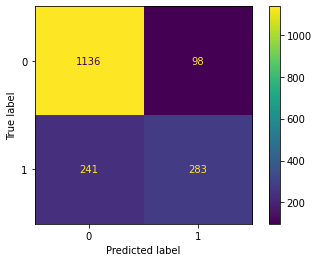

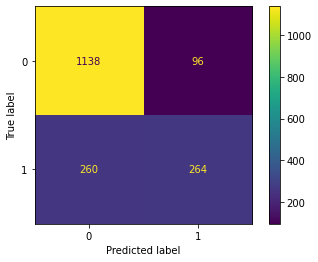

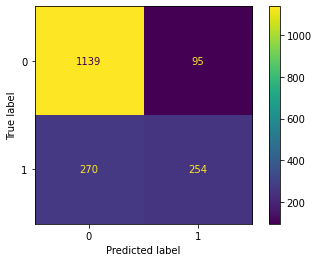

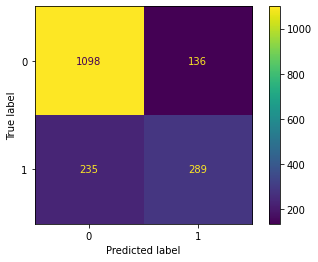

In [34]:
def confusion_matrix(lr_tune,xgb_tune,rf_tune,knn_tune,test_X,test_Y):
  plot_confusion_matrix(lr_tune,test_X,test_Y,values_format='0.0f')
  plot_confusion_matrix(xgb_tune,test_X,test_Y,values_format='0.0f')
  plot_confusion_matrix(rf_tune,test_X,test_Y,values_format='0.0f')
  plot_confusion_matrix(knn_tune,test_X,test_Y,values_format='0.0f')

confusion_matrix(lr_tune,xgb_tune,rf_tune,knn_tune,test_X,test_Y)

__Evaluation Metrics__

Logistic Regression Train
               precision    recall  f1-score   support

           0       0.85      0.90      0.87      3929
           1       0.64      0.53      0.58      1345

    accuracy                           0.80      5274
   macro avg       0.74      0.71      0.73      5274
weighted avg       0.80      0.80      0.80      5274



Logistic Regression Test
               precision    recall  f1-score   support

           0       0.82      0.92      0.87      1234
           1       0.74      0.54      0.63       524

    accuracy                           0.81      1758
   macro avg       0.78      0.73      0.75      1758
weighted avg       0.80      0.81      0.80      1758


XGB Train
               precision    recall  f1-score   support

           0       0.86      0.92      0.89      3929
           1       0.72      0.56      0.63      1345

    accuracy                           0.83      5274
   macro avg       0.79      0.74      0.76      5274
weighte

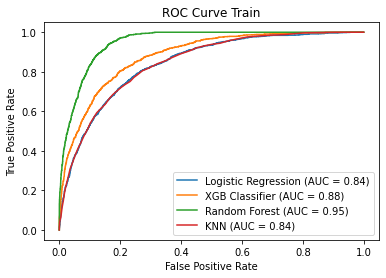

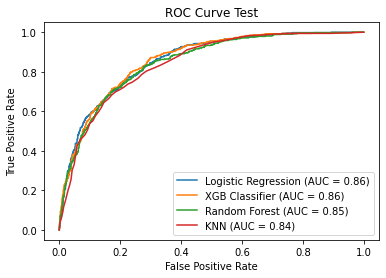

In [36]:
def eva_matrix(lr_tune,xgb_tune,rf_tune,knn_tune,train_X,train_Y,test_X,test_Y):
    ## Report
    print('Logistic Regression Train\n',classification_report(train_Y,lr_tune.predict(train_X)))
    print('\n\nLogistic Regression Test\n',classification_report(test_Y,lr_tune.predict(test_X)))
    print('========================================================================')
    print('\nXGB Train\n',classification_report(train_Y,xgb_tune.predict(train_X)))
    print('\nXGB Test\n',classification_report(test_Y,xgb_tune.predict(test_X)))
    print('========================================================================')
    print('\nRandom Forest Train\n',classification_report(train_Y,rf_tune.predict(train_X)))
    print('\nRandom Forest Test\n',classification_report(test_Y,rf_tune.predict(test_X)))
    print('========================================================================')
    print('\nKNN Train\n',classification_report(train_Y,knn_tune.predict(train_X)))
    print('\nKNN Test\n',classification_report(test_Y,knn_tune.predict(test_X)))

    ## ROC_AUC
    display = plot_roc_curve(lr_tune,train_X,train_Y, name='Logistic Regression')
    plot_roc_curve(xgb_tune,train_X,train_Y,ax=display.ax_, name='XGB Classifier')
    plot_roc_curve(rf_tune,train_X,train_Y,ax=display.ax_, name='Random Forest')
    plot_roc_curve(knn_tune,train_X,train_Y,ax=display.ax_, name='KNN')
    plt.title('ROC Curve Train')

    disp = plot_roc_curve(lr_tune,test_X,test_Y, name='Logistic Regression')
    plot_roc_curve(xgb_tune,test_X,test_Y,ax=disp.ax_, name = 'XGB Classifier')
    plot_roc_curve(rf_tune,test_X,test_Y,ax=disp.ax_, name='Random Forest')
    plot_roc_curve(knn_tune,test_X,test_Y,ax=disp.ax_, name='KNN')
    plt.title('ROC Curve Test')

eva_matrix(lr_tune,xgb_tune,rf_tune,knn_tune,train_X,train_Y,test_X,test_Y)

>Dari data report di atas, __Logistic Regression__ merupakan model terbaik dengan Sensitivity, F1 Score, dan AUC tertingi

In [37]:
def df_report(lr_tune,xgb_tune,rf_tune,knn_tune,test_X,test_Y):
    ## ROC-AUC
    a = roc_auc_score(test_Y, lr_tune.predict_proba(test_X)[:,1])
    b = roc_auc_score(test_Y, xgb_tune.predict_proba(test_X)[:,1])
    c = roc_auc_score(test_Y, rf_tune.predict_proba(test_X)[:,1])
    d = roc_auc_score(test_Y, knn_tune.predict_proba(test_X)[:,1])


    ## Accuracy
    e = classification_report(test_Y,lr_tune.predict(test_X),output_dict=True)['accuracy']
    f = classification_report(test_Y,xgb_tune.predict(test_X),output_dict=True)['accuracy']
    g = classification_report(test_Y,rf_tune.predict(test_X),output_dict=True)['accuracy']
    h = classification_report(test_Y,knn_tune.predict(test_X),output_dict=True)['accuracy']


    ## Precision,Recall,F1
    i = classification_report(test_Y,lr_tune.predict(test_X),output_dict=True)['1']
    j = classification_report(test_Y,xgb_tune.predict(test_X),output_dict=True)['1']
    k = classification_report(test_Y,rf_tune.predict(test_X),output_dict=True)['1']
    l = classification_report(test_Y,knn_tune.predict(test_X),output_dict=True)['1']


    auc = pd.DataFrame({'Model':['Logistic Regression','XGB Classifier','Random Forest','KNN'],
                          'AUC':[a,b,c,d,],
                          'Accuracy':[e,f,g,h]})
    precision = pd.DataFrame([i,j,k,l])
    precision.drop(columns='support',inplace=True)
    df = pd.concat([auc,precision],axis=1)
    return df

report0 = df_report(lr_tune,xgb_tune,rf_tune,knn_tune,test_X,test_Y)
report0

,Model,AUC,Accuracy,precision,recall,f1-score
0,Logistic Regression,0.858942,0.807167,0.742782,0.540076,0.625414
1,XGB Classifier,0.860288,0.797497,0.733333,0.503817,0.597285
2,Random Forest,0.848631,0.792378,0.727794,0.484733,0.581901
3,KNN,0.841902,0.788965,0.680000,0.551527,0.609062


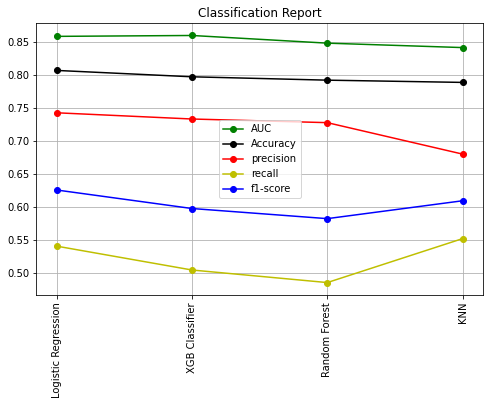

In [38]:
def plot_report(report):
    plt.figure(figsize=(8,5))
    plt.plot(report['Model'], report['AUC'],'g-o',label='AUC')
    plt.plot(report['Model'], report['Accuracy'],'k-o',label='Accuracy')
    plt.plot(report['Model'], report['precision'],'r-o',label='precision')
    plt.plot(report['Model'], report['recall'],'y-o',label='recall')
    plt.plot(report['Model'], report['f1-score'],'b-o',label='f1-score')
    plt.xticks(rotation=90);plt.title('Classification Report')
    plt.grid(True)
    plt.legend()
    plt.show()
    
plot_report(report0)

>__Logistic Regression Tune__ merupakan model terbaik dengan __Recall__, __F1 Score__ dan __AUC__ tertinggi

## Exclude Feature Monthly Charges dan Total Charges

Pada tahap ini saya tidak akan menggunakan Monthly Charges dan Total Charges untuk memprediksi model. Kemudian saya akan membandingkan dengan model sebelumnya yang menggunakan feature MonthlyCharges dan Total Charges

### Spliting Data

In [39]:
train_X1 = train_X[:,:-2]
test_X1 = test_X[:,:-2]
train_Y1 = train_Y
test_Y1 = test_Y

### Hyper Parameter Tuning

__Logistic Regression__

In [40]:
# param_lr = {
#     'solver':['newton-cg','lbfgs','liblinear','sag','saga'], ##algoritma Logistic regression
#     'penalty':['none','l1','l2','elasticnet','none'], # regularisasi
#       'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] #strong of regularisasi
# }

param_lr = {
    'solver':['saga'], ##algoritma Logistic regression
    'penalty':['l1'], # regularisasi
    'C': [1] #strong of regularisasi
}
kf = KFold(n_splits=5, random_state=111, shuffle=False)

lr_pipeline = make_pipeline(LogisticRegression())
new_params = {'logisticregression__' + key: param_lr[key] for key in param_lr}
lr1_tune = GridSearchCV(lr_pipeline, param_grid=new_params, cv=kf, scoring='f1',
                        return_train_score=True)
lr1_tune.fit(train_X1, train_Y1)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_class='auto',
                                                           n_jobs=None,
                                                           penalty='l2',
                                                  

In [41]:
# lr1_tune.best_params_

# {'logisticregression__C': 1,
#  'logisticregression__penalty': 'l1',
#  'logisticregression__solver': 'saga'}

__Parameter Tuning XGB Classifier__

In [42]:
# param =  {"learning_rate"    : [int(x)/100 for x in np.linspace(1, 10, 10)] ,
#           "min_child_weight" : [int(x) for x in np.linspace(1, 10, 10)],
#           "gamma"            : [int(x)/10 for x in np.linspace(1, 10, 10)],
#           "max_depth"        : [int(x) for x in np.linspace(1, 10, 10)] ,
#           "colsample_bytree" : [int(x)/10 for x in np.linspace(1, 10, 10)] }

param =  {"learning_rate"    : [0.05] ,
          "min_child_weight" : [7],
          "gamma"            : [0.2],
          "max_depth"        : [5] ,
          "colsample_bytree" : [0.7] }

kf = KFold(n_splits=5, random_state=111, shuffle=False)

xgb_pipeline = make_pipeline(XGBClassifier())
new_params = {'xgbclassifier__' + key: param[key] for key in param}
xgb1_tune = GridSearchCV(xgb_pipeline, param_grid=new_params, cv=kf, scoring='f1',
                        return_train_score=True)
xgb1_tune.fit(train_X1, train_Y1)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('xgbclassifier',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      gamma=0,
                                                      learning_rate=0.1,
                                                      max_delta_step=0,
                                                      max_depth=3,
                                                      min_child_weight=1,
                                                      missing=None,
                  

In [44]:
# xgb_tune.best_params_

# {'colsample_bytree': 0.3,
#  'gamma': 0.2,
#  'learning_rate': 0.2,
#  'max_depth': 3,
#  'min_child_weight': 5}

__Random Forest__

In [45]:
# param= {
#     'n_estimators': [10,50,100], ## jumlah tree
#     'criterion':['gini','entropy'], ## algoritma tree
#     'max_depth': [int(x) for x in np.linspace(10, 100, 10)],
# }

param= {
    'n_estimators': [50], ## jumlah tree
    'criterion':['entropy'], ## algoritma tree
    'max_depth': [10],
}
kf = KFold(n_splits=5, random_state=111, shuffle=False)

rf_pipeline = make_pipeline(RandomForestClassifier())
new_params = {'randomforestclassifier__' + key: param[key] for key in param}
rf1_tune = GridSearchCV(rf_pipeline, param_grid=new_params, cv=kf, scoring='f1',
                        return_train_score=True)
rf1_tune.fit(train_X1, train_Y1)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('randomforestclassifier',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               max_samples=None,
                                                               min_impurity_decrease=0.0,
                                                     

In [46]:
# rf1_tune.best_params_

# {'randomforestclassifier__criterion': 'entropy',
#  'randomforestclassifier__max_depth': 10,
#  'randomforestclassifier__n_estimators': 50}

__KNN__

In [47]:
# param = {
#         'n_neighbors' : list(range(50,100)), ## jumlah n neighbors
#         'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'], # struktur data
# }
param = {
        'n_neighbors' : [83], ## jumlah n neighbors
        'algorithm':['brute'], # struktur data
}
kf = KFold(n_splits=5, random_state=111, shuffle=False)

knn_pipeline = make_pipeline(KNeighborsClassifier())
new_params = {'kneighborsclassifier__' + key: param[key] for key in param}
knn1_tune = GridSearchCV(knn_pipeline, param_grid=new_params, cv=kf, scoring='f1',
                        return_train_score=True)
knn1_tune.fit(train_X1, train_Y1)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('kneighborsclassifier',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'kneighborsclassifier__algorithm': ['brute'],
                         'kneighborsclassifier__n_neighbors': [83]},
       

In [48]:
# knn1_tune.best_params_

# {'kneighborsclassifier__algorithm': 'brute',
#  'kneighborsclassifier__n_neighbors': 83}

### Evaluation

Logistic Regression Train
               precision    recall  f1-score   support

           0       0.85      0.90      0.87      3929
           1       0.65      0.52      0.58      1345

    accuracy                           0.80      5274
   macro avg       0.75      0.71      0.72      5274
weighted avg       0.79      0.80      0.80      5274



Logistic Regression Test
               precision    recall  f1-score   support

           0       0.82      0.92      0.87      1234
           1       0.74      0.54      0.62       524

    accuracy                           0.81      1758
   macro avg       0.78      0.73      0.75      1758
weighted avg       0.80      0.81      0.80      1758


XGB Train
               precision    recall  f1-score   support

           0       0.85      0.92      0.88      3929
           1       0.69      0.54      0.60      1345

    accuracy                           0.82      5274
   macro avg       0.77      0.73      0.74      5274
weighte

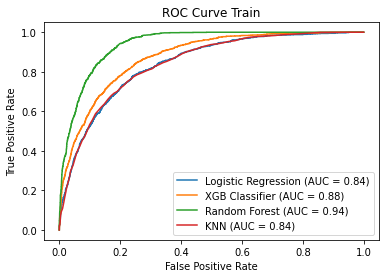

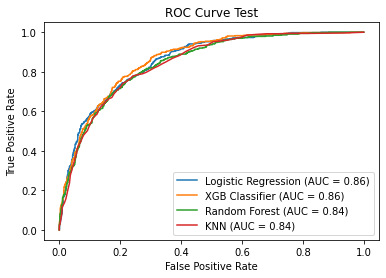

In [49]:
eva_matrix(lr1_tune,xgb1_tune,rf1_tune,knn1_tune,train_X1,train_Y1,test_X1,test_Y1)

In [50]:
report1 = df_report(lr1_tune,xgb1_tune,rf1_tune,knn1_tune,test_X1,test_Y1)
report1

,Model,AUC,Accuracy,precision,recall,f1-score
0,Logistic Regression,0.856870,0.806598,0.740838,0.540076,0.624724
1,XGB Classifier,0.861879,0.799772,0.738889,0.507634,0.601810
2,Random Forest,0.844901,0.793515,0.718157,0.505725,0.593505
3,KNN,0.844112,0.792947,0.683486,0.568702,0.620833


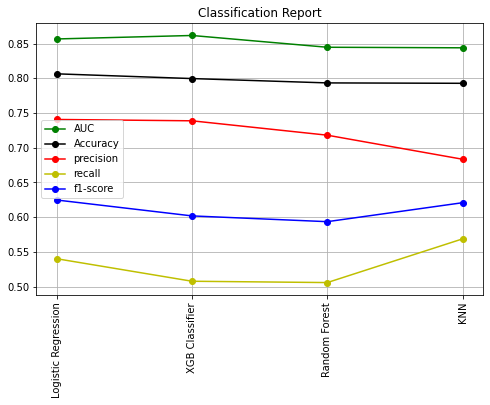

In [51]:
plot_report(report1)

>__Logistic Regression__ memiliki AUC dan F1 Score, dan Recall tertinggi, untuk percobaan selanjutnya saya akan mencoba memaksimalkan Logistic Regression dengan melakukan train menggunakan dataset yang diseimbangkan terlebih dahulu

### Perbandingan model dengan menghilangkan Feature Monthly Charges dan Total Charges

Pada tahap ini saya ingin melihat apakah dengan membuang feature Monthly Charges dan Total Charges bisa mempengaruhi model atau tidak, saya menggunakan model terbaik sebagai perbandingan

Logistic Regression 1
               precision    recall  f1-score   support

           0       0.82      0.92      0.87      1234
           1       0.74      0.54      0.63       524

    accuracy                           0.81      1758
   macro avg       0.78      0.73      0.75      1758
weighted avg       0.80      0.81      0.80      1758

Logistic Regression 2
               precision    recall  f1-score   support

           0       0.82      0.92      0.87      1234
           1       0.74      0.54      0.62       524

    accuracy                           0.81      1758
   macro avg       0.78      0.73      0.75      1758
weighted avg       0.80      0.81      0.80      1758



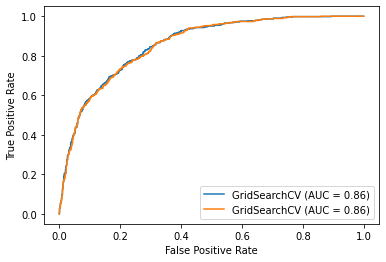

In [52]:
print('Logistic Regression 1\n',classification_report(test_Y,lr_tune.predict(test_X)))
print('Logistic Regression 2\n',classification_report(test_Y1,lr1_tune.predict(test_X1)))

## ROC_AUC
disp = plot_roc_curve(lr_tune,test_X,test_Y)
plot_roc_curve(lr1_tune,test_X1,test_Y1,ax=disp.ax_)

>Berdasarkan report klasifikasi dan grafik ROC-AUC diatas, dapat disimpulkan bahwa membuang feature Monthly Charges dan Total Charges tidak mempengaruhi model.

<hr>

# 2. Percobaan 2 (Under Sampling)

Dalam dataset ini __class 0__ : 5163, sedangkan __class 1__ : 1869, saya akan menggunakan ```NearMiss``` untuk menyeimbangkan class, teknik ini akan menghapus beberapa sample majority class yaitu __class 0__ sehingga jumlahnya sama dengan minority __class 1__ , ```NearMiss``` akan menghapus majority class yang memiliki jarak terdekat dari minority class.[source](https://machinelearningmastery.com/undersampling-algorithms-for-imbalanced-classification/)

In [ ]:
train_X2 = train_X1.copy()
train_Y2 = train_Y1.copy()
test_X2 = test_X1
test_Y2 = test_Y1

__Parameter Tuning Logistic Regression__

In [ ]:
# param_lr = {
#     'solver':['newton-cg','lbfgs','liblinear','sag','saga'], ##algoritma Logistic regression
#     'penalty':['none','l1','l2','elasticnet','none'], # regularisasi
#       'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] #strong of regularisasi
# }
param_lr = {
    'solver':['saga'], ##algoritma Logistic regression
    'penalty':['l1'], # regularisasi
      'C': [0.1] #strong of regularisasi
}
kf = KFold(n_splits=5, random_state=111, shuffle=False)
lr_pipeline = make_pipeline(NearMiss(),LogisticRegression())
new_params = {'logisticregression__' + key: param_lr[key] for key in param_lr}
lr2_tune = GridSearchCV(lr_pipeline, param_grid=new_params, cv=kf, scoring='f1',
                        return_train_score=True)
lr2_tune.fit(train_X2, train_Y2)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('nearmiss',
                                        NearMiss(n_jobs=None, n_neighbors=3,
                                                 n_neighbors_ver3=3,
                                                 sampling_strategy='auto',
                                                 version=1)),
                                       ('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None...
          

In [ ]:
# lr2_tune.best_params_

# {'logisticregression__C': 0.1,
#  'logisticregression__penalty': 'l1',
#  'logisticregression__solver': 'saga'}

{'logisticregression__C': 0.1,
 'logisticregression__penalty': 'l1',
 'logisticregression__solver': 'saga'}

# 3. Percobaan 3 (Random Over Sampling)

Pada percobaan ke 3 ini saya akan menggunakan ```RandomOverSampler``` untuk menyeimbangkan class, teknik ini akan menduplikasi minority class (__class 1__) secara random sehingga total __class 1__ akan sama dengan majority class  (__class 0__)

In [53]:
train_X3 = train_X1
train_Y3 = train_Y1
test_X3 = test_X1
test_Y3 = test_Y1

__Parameter Tuning Logistic Regression__

In [ ]:
# param_lr = {
#     'solver':['newton-cg','lbfgs','liblinear','sag','saga'], ##algoritma Logistic regression
#     'penalty':['none','l1','l2','elasticnet','none'], # regularisasi
#       'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] #strong of regularisasi
# }

param_lr = {
    'solver':['newton-cg'], ##algoritma Logistic regression
    'penalty':['none'], # regularisasi
      'C': [0.001] #strong of regularisasi
}
kf = KFold(n_splits=5, random_state=111, shuffle=False)
lr_pipeline = make_pipeline(RandomOverSampler(),LogisticRegression())
new_params = {'logisticregression__' + key: param_lr[key] for key in param_lr}
lr3_tune = GridSearchCV(lr_pipeline, param_grid=new_params, cv=kf, scoring='f1',
                        return_train_score=True)
lr3_tune.fit(train_X3, train_Y3)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('randomoversampler',
                                        RandomOverSampler(random_state=None,
                                                          sampling_strategy='auto')),
                                       ('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                  

In [ ]:
# lr3_tune.best_params_

# {'logisticregression__C': 0.001,
#  'logisticregression__penalty': 'none',
#  'logisticregression__solver': 'newton-cg'}

{'logisticregression__C': 0.001,
 'logisticregression__penalty': 'none',
 'logisticregression__solver': 'newton-cg'}

# 4. Percobaan 4 (SMOTE)

Pada percobaan ke 4 ini saya akan menggunakan ```SMOTE``` _Synthetic Minority Oversampling Technique_ untuk menyeimbangkan class sehingga minority class akan memiliki jumlah yang sama dengan majority class, berbeda dengan Random Over Sample, SMOTE membuat instance data baru berdasarkan jarak euclidian terdekat, teknik ini mengadopsi algoritma K-Nearest Neighbors.[source](http://etd.repository.ugm.ac.id/home/detail_pencarian/157692)

In [54]:
train_X4 = train_X1
train_Y4 = train_Y1
test_X4 = test_X1
test_Y4 = test_Y1

__Parameter Tuning Logistic Regression__

In [ ]:
# param_lr = {
#     'solver':['newton-cg','lbfgs','liblinear','sag','saga'], ##algoritma Logistic regression
#     'penalty':['none','l1','l2','elasticnet','none'], # regularisasi
#       'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] #strong of regularisasi
# }

param_lr = {
    'solver':['saga'], ##algoritma Logistic regression
    'penalty':['none'], # regularisasi
      'C': [0.1] #strong of regularisasi
}
kf = KFold(n_splits=5, random_state=111, shuffle=False)
lr_pipeline = make_pipeline(SMOTE(),LogisticRegression())
new_params = {'logisticregression__' + key: param_lr[key] for key in param_lr}
lr4_tune = GridSearchCV(lr_pipeline, param_grid=new_params, cv=kf, scoring='f1',
                        return_train_score=True)
lr4_tune.fit(train_X4, train_Y4)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('smote',
                                        SMOTE(k_neighbors=5, n_jobs=None,
                                              random_state=None,
                                              sampling_strategy='auto')),
                                       ('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
            

In [ ]:
# lr4_tune.best_params_

# {'logisticregression__C': 0.1,
#  'logisticregression__penalty': 'none',
#  'logisticregression__solver': 'saga'}

{'logisticregression__C': 0.1,
 'logisticregression__penalty': 'none',
 'logisticregression__solver': 'saga'}

# Best Model

Memilih model terbaik dari 4 percobaan di atas

In [ ]:
## ROC-AUC
a = roc_auc_score(test_Y1, lr1_tune.predict_proba(test_X1)[:,1])
b = roc_auc_score(test_Y2, lr2_tune.predict_proba(test_X2)[:,1])
c = roc_auc_score(test_Y3, lr3_tune.predict_proba(test_X3)[:,1])
d = roc_auc_score(test_Y4, lr4_tune.predict_proba(test_X4)[:,1])

## Accuracy

e = classification_report(test_Y1,lr1_tune.predict(test_X1),output_dict=True)['accuracy']
f = classification_report(test_Y2,lr2_tune.predict(test_X2),output_dict=True)['accuracy']
g = classification_report(test_Y3,lr3_tune.predict(test_X3),output_dict=True)['accuracy']
h = classification_report(test_Y4,lr4_tune.predict(test_X4),output_dict=True)['accuracy']

## Precision,Recall,F1

i = classification_report(test_Y1,lr1_tune.predict(test_X1),output_dict=True)['1']
j = classification_report(test_Y2,lr2_tune.predict(test_X2),output_dict=True)['1']
k = classification_report(test_Y3,lr3_tune.predict(test_X3),output_dict=True)['1']
l = classification_report(test_Y4,lr4_tune.predict(test_X4),output_dict=True)['1']

model = pd.DataFrame({'Model':['Logistic Regression1','Logistic Regression2','Logistic Regression3','Logistic Regression4'],
                      'AUC':[a,b,c,d],
                      'Accuracy':[e,f,g,h]})
report = pd.DataFrame([i,j,k,l])
report.drop(columns='support',inplace=True)
report5 = pd.concat([model,report],axis=1)
report5

,Model,AUC,Accuracy,precision,recall,f1-score
0,Logistic Regression1,0.856869,0.806598,0.740838,0.540076,0.624724
1,Logistic Regression2,0.805660,0.699659,0.497669,0.814885,0.617945
2,Logistic Regression3,0.855687,0.759386,0.570629,0.778626,0.658596
3,Logistic Regression4,0.856140,0.765643,0.580229,0.772901,0.662848


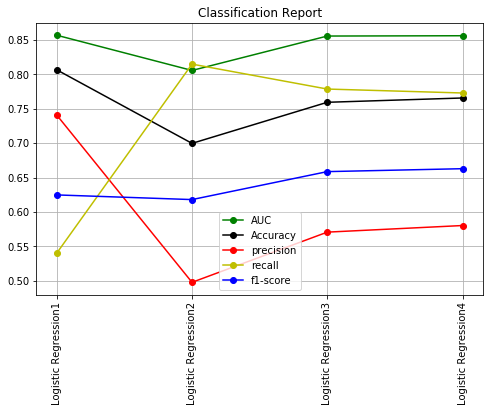

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(report5['Model'], report5['AUC'],'g-o',label='AUC')
plt.plot(report5['Model'], report5['Accuracy'],'k-o',label='Accuracy')
plt.plot(report5['Model'], report5['precision'],'r-o',label='precision')
plt.plot(report5['Model'], report5['recall'],'y-o',label='recall')
plt.plot(report5['Model'], report5['f1-score'],'b-o',label='f1-score')
plt.xticks(rotation=90);plt.title('Classification Report')
plt.grid(True)
plt.legend()
plt.show()

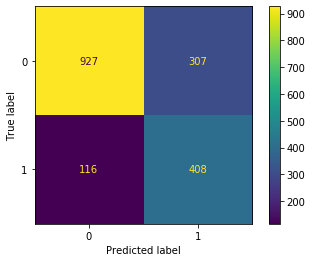

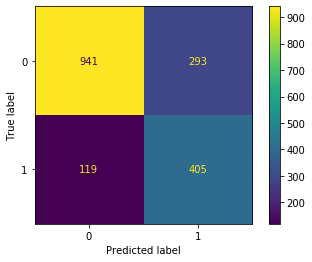

In [ ]:
plot_confusion_matrix(lr3_tune,test_X3,test_Y3,values_format='0.0f')
plot_confusion_matrix(lr4_tune,test_X4,test_Y4,values_format='0.0f')

>__Saya memilih model Logistic Regression 3, yaitu model yang kita train dengan data balance Random Over Sample sebagai model terbaik__

## Cek for OverFitting/UnderFitting

In [ ]:
print('Logistic Regression Training\n',classification_report(train_Y3,lr3_tune.predict(train_X3)))
print('Logistic Regression Testing\n',classification_report(test_Y3,lr3_tune.predict(test_X3)))

Logistic Regression Training
               precision    recall  f1-score   support

           0       0.91      0.73      0.81      3929
           1       0.50      0.80      0.62      1345

    accuracy                           0.75      5274
   macro avg       0.71      0.77      0.72      5274
weighted avg       0.81      0.75      0.76      5274

Logistic Regression Testing
               precision    recall  f1-score   support

           0       0.89      0.75      0.81      1234
           1       0.57      0.78      0.66       524

    accuracy                           0.76      1758
   macro avg       0.73      0.76      0.74      1758
weighted avg       0.79      0.76      0.77      1758



- Model Logistic Regression tidak over fitting

# Save Model

In [ ]:
import joblib

In [ ]:
# joblib.dump(lr4_tune,'lr_best_model')

['lr_best_model']